In [140]:
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
import numpy as np
import boto3

bucketname='nyg-hackathon-525684156106'

def makemap(gameid,playid):
    
    s3=boto3.resource('s3')
    
    #Get all the plays first
    itemname='movethechains/athena_runtime_queries/identified_games.csv'
    obj = s3.Object(bucketname, itemname)
    
    identified_plays=pd.read_csv(obj.get()['Body'])
    identified_plays.head()
    
    #Figure out if the posession team was the home team or the away team and who the RB was
    identified_plays=identified_plays[identified_plays.play_id==playid]
    identified_plays=identified_plays[identified_plays.game_id==gameid]
    identified_plays.reset_index(inplace=True)
    RB_gsis=identified_plays.rusher_player_id[0]
    posteam='hometeam'
    if(identified_plays.posteam[0]==identified_plays.away_team[0]):
        posteam='awayteam'
        
    #Now get the tracking data
    itemname='movethechains/athena_runtime_queries/'+'gameid_'+str(gameid)+'_playid_'+str(playid)+'.csv'
    obj = s3.Object(bucketname, itemname)
    playdata=pd.read_csv(obj.get()['Body'])
    if(posteam=='hometeam'):
        posteamtracking=playdata.hometrackingdata[0]
        defteamtracking=playdata.awaytrackingdata[0]
    else:
        posteamtracking=playdata.awaytrackingdata[0]
        defteamtracking=playdata.hometrackingdata[0]
    
    #Based on the defteam positions at each timestamp, build out the map
    defteamplayertracking=defteamtracking.split('}]},')
    re_time=re.compile('time=[\S]{23}')
    timestamps=re_time.findall(defteamplayertracking[0])
    num_timestamps=len(timestamps)
    GRIDS=[]
    RAW_GRIDS=[]
    
    re_x=re.compile('x=[-]*[0-9]+[.]*[0-9]*')
    re_y=re.compile('y=[-]*[0-9]+[.]*[0-9]*')
    re_dir=re.compile('dir=[-]*[0-9]+[.]*[0-9]*')
    re_onfield=re.compile('isonfield=[\S]{5}')
    
    #For each player in the defensive tracking data fill out the respective grid
    POS=[]
    for i in range(num_timestamps):
        POS.append([])
    
    r_tackle=5
    for defplayer in range(len(defteamplayertracking)):       
        x_raw=re_x.findall(defteamplayertracking[defplayer])
        y_raw=re_y.findall(defteamplayertracking[defplayer])
        dir_raw=re_dir.findall(defteamplayertracking[defplayer])
        onfield=re_onfield.findall(defteamplayertracking[defplayer])
        for i in range(num_timestamps):
            x_pos=int(float(x_raw[i].split('=')[1]))
            y_pos=int(float(y_raw[i].split('=')[1]))
            if('true' in onfield[i] and x_pos<100 and y_pos<55):
                POS[i].append((x_pos,y_pos))
    
    for i in range(num_timestamps):
        map=np.zeros((100,55))
        fatmap=np.zeros((100,55))
        for playerpos in POS[i]:
            map[playerpos[0],playerpos[1]]=1
            seed=(playerpos[0]-r_tackle,playerpos[1]-r_tackle)
            obs_x=seed[0]
            obs_y=seed[1]
            while obs_x<seed[0]+(r_tackle):
                while obs_y<seed[1]+(r_tackle):
                    if(obs_x>0 and obs_x<100 and obs_y>0 and obs_y<55):
                        fatmap[obs_x,obs_y]=1
                    #f((obs_x<0 or obs_x>99) and (obs_y>0 and obs_y<55)):
                        #atmap[playerpos[0],obs_y]=1
                    #f((obs_x>0 and obs_x<100) and (obs_y<0 and obs_y>55)):
                        #atmap[obs_x,playerpos[1]]=1
                    obs_y=obs_y+1
                obs_x=obs_x+1
            #if(playerpos[0]>1 and playerpos[0]<99):
                #fatmap[playerpos[0]+r_tackle,playerpos[1]]=1
                #fatmap[playerpos[0]-r_tackle,playerpos[1]]=1
            #if(playerpos[1]>1 and playerpos[0]<54):
                #fatmap[playerpos[0],playerpos[1]+r_tackle]=1
                #fatmap[playerpos[0],playerpos[1]-r_tackle]=1
        RAW_GRIDS.append(map)
        GRIDS.append(fatmap)
            
       
    
    SERIALIZED_GRIDS=[]
    for grid in GRIDS:
        serialized=[]
        for i in range(100):
            for j in range(55):
                serialized.append(grid[i,j])
        SERIALIZED_GRIDS.append(serialized)
    
    #Identify the running back and get his position
    offteamplayertracking=posteamtracking.split('}]},')
    re_gsis=re.compile('gsisid=[\S]{10}')
    gsis_ids=re_gsis.findall(posteamtracking)
    RB_POS=[(0,0,0)]*num_timestamps
    
    for i in range(len(gsis_ids)):
        if(RB_gsis==gsis_ids[i].split('=')[1]):
            player_index=i
            break
        
    rb_x_raw=re_x.findall(offteamplayertracking[player_index])
    rb_y_raw=re_y.findall(offteamplayertracking[player_index])
    rb_dir_raw=re_dir.findall(offteamplayertracking[player_index])
    for i in range(num_timestamps):
        rbpos=[int(float(rb_x_raw[i].split('=')[1])),int(float(rb_y_raw[i].split('=')[1])),0]
        RB_POS[i]=rbpos
        if(i>0):
            try:
                angle=np.arctan((RB_POS[i][1]-RB_POS[i-1][1])/(RB_POS[i][1]-RB_POS[i-1][0]))*(180/np.pi)
            except:
                angle=90
            RB_POS[i][2]=angle
    
    #Figure out play direction
    approx_scrimmage_x=int(float(re_x.findall(defteamplayertracking[0])[0].split('=')[1]))
    direction='Right'
    if(RB_POS[0][0]>approx_scrimmage_x):
        direction='Left'
    
    #Prep data for A*
    pack={
        'GRIDS':GRIDS,
        'SERIALIZED_GRIDS':SERIALIZED_GRIDS,
        'RAW GRIDS':RAW_GRIDS,
        'RBPOS':RB_POS,
        'YARDS':identified_plays.yards_gained[0],
        'DIRECTION':direction,
        'TIMESTAMPS':timestamps,
    }
    return pack

In [286]:
class Node:
    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position
        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        return self.position == other.position


def astar(maze, start, end):
    # Create start and end node
    start_node = Node(None, start)
    start_node.g = start_node.h = start_node.f = 0
    end_node = Node(None, end)
    end_node.g = end_node.h = end_node.f = 0

    # Initialize both open and closed list
    open_list = []
    closed_list = []

    # Add the start node
    open_list.append(start_node)

    # Loop until you find the end
    while len(open_list) > 0:

        # Get the current node
        current_node = open_list[0]
        current_index = 0
        for index, item in enumerate(open_list):
            if item.f < current_node.f:
                current_node = item
                current_index = index

        # Pop current off open list, add to closed list
        open_list.pop(current_index)
        closed_list.append(current_node)

        # Found the goal with updated end_goal y position
        end_node = Node(end_node.parent, tuple([end_node.position[0], current_node.position[1]]))
        if current_node == end_node:
            path = []
            current = current_node
            while current is not None:
                path.append(current.position)
                current = current.parent
            return path[::-1]  # Return reversed path

        # Generate children
        children = []
        for new_position in [(0, -1), (0, 1), (-1, 0), (1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]:  # Adjacent squares

            # Get node position
            node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1])

            # Make sure within range
            if node_position[0] > (len(maze) - 1) or node_position[0] < 0 or node_position[1] > (
                    len(maze[len(maze) - 1]) - 1) or node_position[1] < 0:
                continue

            # Make sure walkable terrain
            if maze[node_position[0]][node_position[1]] != 0:
                continue

            # Create new node
            new_node = Node(current_node, node_position)

            # Append
            children.append(new_node)

        # Loop through children
        for child in children:

            # Child is on the closed list
            for closed_child in closed_list:
                if child == closed_child:
                    continue

            # Create the f, g, and h values
            child.g = current_node.g + 1
            child.h = abs(child.position[0] - end_node.position[0]) + abs(child.position[1] - end_node.position[1])
            child.f = child.g + child.h

            # Child is already in the open list
            for open_node in open_list:
                if child == open_node and child.g > open_node.g:
                    continue

            # Add the child to the open list
            open_list.append(child)

def play_angle(x,y):
    angle = 0
    if x == 1 and y == 0:
        angle = 0
        
    elif x == 1 and y == 1:
        angle = 45

    elif x == 0 and y == 1:
        angle = 90

    elif x == -1 and y == 1:
        angle = 135

    elif x == -1 and y == 0:
        angle = 180

    elif x == -1 and y == -1:
        angle = 225

    elif x == 0 and y == -1:
        angle = 270

    elif x == 1 and y == -1:
        angle = 315

    else:
        angle = 0
        
    return angle

def astar_algorithm():
    
    # Get and create player map
    output = makemap(2020020200,2146)
#     print("makemap done")
#     print(output['RBPOS'])
#     print(output['RBPOS'][0], output['DIRECTION'], output['YARDS'])
    
    actual_x = []
    actual_y = []
    for i in output['RBPOS']:
        actual_x.append(i[0])
        actual_y.append(i[1])  
   
    all_grids = []
    for j in range(len(output['GRIDS'])):
        maze = output['GRIDS'][j]
        serial = maze.flatten().astype(int).tolist()
        row = []
        grid = []
        for index in range(len(serial)):
            row.append(int(serial[index]))
            if index > 0 and (index + 1) % 55 == 0:
                grid.append(row)
                row = []
        all_grids.append(grid)
   

    start = (actual_x[0], actual_y[0])
    end = (actual_x[0] - output['YARDS'], actual_y[0])
#     print(end)
    
    list_of_optimal_paths = []
    optimal_angles = []
    optimal_step = [start]
    
#     print(len(all_grids))
    
    for i in range(len(all_grids)):
        start = (actual_x[i], actual_y[i])
        path = (astar(all_grids[i], start, end))
        
        list_of_optimal_paths.append(path)
        
        if len(path) > 1:
            optimal_step.append(path[1])
            
#     print("paths:", len(optimal_step))
            
    for i in range(len(optimal_step) - 1):            
        x = optimal_step[i+1][0] - optimal_step[i][0]
        y = optimal_step[i+1][1] - optimal_step[i][1]
        optimal_angles.append(play_angle(x,y))  
        
#     print("angles:", len(optimal_angles))

#     for coords in path[2:]:
#         optimal_path.append(coords)
        
        
#     for c in range(len(optimal_path[:-1])):
#         x = optimal_path[c+1][0] - optimal_path[c][0]
#         y = optimal_path[c+1][1] - optimal_path[c][1]
#         optimal_angles.append(play_angle(x,y))
        
        
   
    actual_angles = []
    for o in range(len(output['RBPOS']) - 1):
        x = output['RBPOS'][o+1][0] - output['RBPOS'][o][0]
        y = output['RBPOS'][o+1][1] - output['RBPOS'][o][1]
        actual_angles.append(play_angle(x,y))
           
    aangles = []
#     print("optimal", len(optimal_angles))
    
    if len(optimal_angles) < len(actual_angles):
        for i in range(len(optimal_angles)):
            aangles.append(actual_angles[i])
        
    else:    
        tmp = []
        for i in range(len(actual_angles)):
            aangles.append(actual_angles[i])
            tmp.append(optimal_angles[i])
        
        optimal_angles = tmp
#     print("aangles", len(aangles))
#     print(len(actual_angles))
        
        
    x_path = []
    y_path = []
    x_maze = []
    y_maze = []
    
    ts = 190
                   
    for coord in list_of_optimal_paths[ts]:
        x_path.append(coord[0])
        y_path.append(coord[1])
        

    for x_coord in range(len(all_grids[ts])):
        for y_coord in range(len(all_grids[ts][0])):
            if all_grids[ts][x_coord][y_coord] == 1:
                x_maze.append(x_coord)
                y_maze.append(y_coord)
                
#     print((x_path), y_path)
    print(len(actual_x), len(actual_y))
    
    plt.plot(x_maze, y_maze, 'ro ', ms=5, label='Blockers')
    plt.plot(x_path, y_path, 'g.', ms=10, label ='Optimal Path')
    plt.plot(actual_x[190:], actual_y[190:], 'k.',ms=5, label ='Actual Path')
    plt.axis(xmin=0, xmax=100, ymin=0, ymax=56)
    plt.grid()
    plt.xticks(np.arange(0, 100, step=10))
    plt.yticks(np.arange(0, 56, step=5))
    plt.legend(loc="upper left")
    plt.tight_layout()
#     plt.show()
    plt.savefig('2020020200_2146_190ts.png')

    return optimal_angles, aangles

(194, 194)
86.99625958884918


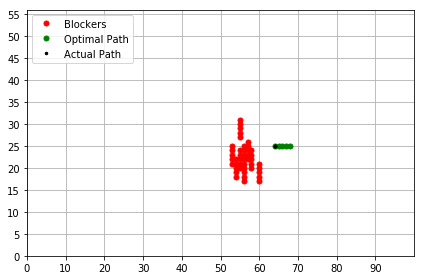

In [287]:
def rbiqCalc(direction, opt):
    # direction: direction of run in degrees
    # opt: optimal path direction in degrees
    
    dirRad = direction * np.pi / 180;
    optRad = opt * np.pi / 180;
    
    diff = optRad - dirRad;
    RBIQ = (50 * np.cos(diff)) + 50;
    
    return RBIQ

def listRun(dirList, optList):
    i = 0;
    sum = 0;
    
    listlength = len(dirList);
    if listlength != len(optList):
        return
    
    while i < listlength-1:
        sum = sum + rbiqCalc(dirList[i+1], optList[i]);
        i = i + 1;
        
    RBIQ = sum / (listlength-1);
    return RBIQ

def main():
    optList, dirList = astar_algorithm()
#     print("astar done")
#     print(len(optList), len(dirList))
    
#     dirList = [45, 45, 46, 48, 50];
#     optList = [50, 60, 65, 66, 65];
    
    RBIQ = listRun(dirList, optList);
    print(RBIQ);

if __name__ == '__main__':
    main()